In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm.notebook import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

from bs_transfer import *
from bs_net import *
from bs_gameclass import *
from bs_helpers import *
from bs_selfplay import *

## Training

In [3]:

# Batch generator for neural network training


def batchgen(gamerecords, size=50, istart=0, iend=0, augment=True, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    if not iend: iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ps = np.zeros((size, SX, SY, 1))
            vs = np.zeros((size, 1))
            for i, k in enumerate(mb):
                s, a, r = gamerecords[k]
                
                '''
                if np.random.rand()<.5:
                    s = GameIsola.mirrorx_state(s)
                    adist = mirrorx_dist(adist)
                if np.random.rand()<.5:
                    s = GameIsola.mirrory_state(s)
                    adist = mirrorx_dist(adist)'''
                    
                xs[i] = encode_x(s.sea, s.det)
                ps[i, a] = 1.
                vs[i] = r
                    
            yield xs, ps, vs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
         
        
        
        

def train(net, gamerecords, gamerecords_legacy=None, iterations=4000, verbose=0):
    '''Trainiert das Netz'''

    try: net.optimizer
    except:
        net.optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=0e-4)
    optimizer = net.optimizer
    bg_v = batchgen(gamerecords, iend=500, size=500)
    bg_s = batchgen(gamerecords, istart=500, size=200, verbose='supervised')
    #bg_u = batchgen(gamerecords_legacy, size=400)
    celoss = nn.CrossEntropyLoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(torch.sum(-yt*torch.log(yp+1e-12), dim=1))
    losses1 = []
    losses2 = []
    ###semlosses = []
    ###mtlosses = []


    def valloss():
        x, tp, tv = next(bg_v)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)

        loss1 = LogLoss(pp, tp)
        loss2 = MSE(pv[:,0], tv[:,0])
        return loss1.item(), loss2.item()

    
    for k in trange(iterations):
        x, tp, tv = next(bg_s)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)
        #tp = tp.type(torch.long)

        loss1 = LogLoss(pp, tp)
        loss2 = MSE(pv[:,0], tv[:,0])
        loss = loss1 + loss2
        loss.backward()

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()

        # Statistic
        losses1 += [loss1.item()]
        losses2 += [loss2.item()]

        # Verbose output, measure minimum val loss
        if len(losses1) == 100:
            vloss1, vloss2 = valloss()
            if verbose>=1:
                print('Loss1=%f, Loss12=%f, ValLoss1=%f, ValLoss2=%f'% (np.mean(losses1), np.mean(losses2), vloss1, vloss2))
            losses1, losses2 = [], []
            
    return net

In [128]:
#newgames = selfplay(MultiMCTS(nparallel=1, nsearches=50, net=net), ngames=200, verbose=1)  # 25 min für 200 games!
#newgames = selfplay(MultiMCTS(nparallel=10, nsearches=50, net=net), ngames=200, verbose=1)  #  5 min für 200 games! batching verschlechtert spielperformance ein wenig!
#newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1) # 3 min für 200 games!

In [4]:
from isola_net import NetAdaptive as Net

net = Net()
frame = 1
game_rec = []
winrates = []
mmdepths=[]
depthminimax = 2
stage = 0

print(f'Game record has length {len(game_rec)}')

Game record has length 0


In [5]:


depthminimax = 3
frame = 1
stage = 1

while True:

    
    # Evaluate/Pit
    if stage==0:
        print('Pitting')
        winrate = pit(MultiMCTS(nparallel=1, nsearches=100, net=net), MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)
        print(winrate)
        winrates.append(winrate)
        mmdepths.append(depthminimax)
        plt.plot(winrates, 'C2')
        plt.plot(np.array(mmdepths)/10, 'C0o-', lw=0.5)
        plt.show()
        if winrate>=1.0 and depthminimax<2:
            depthminimax += 1
            print(f'Changing minimax depth to {depthminimax}')
        stage = 1
    
    
    # Selfplay
    if stage==1:
        print('Selfplay')
        #newgames = selfplay(MultiMCTS(nparallel=5, nsearches=50, net=net), ngames=200, verbose=1)
        newgames = selfplay_batched(BatchMCTS(nparallel=15, nsearches=500, net=net, params={'useQ':True,'cpuct':0.2}), ngames=50, verbose=1) #50
        newgames += load_selfplay()
        game_rec = newgames + game_rec
        print('number of new states:', len(newgames))
        print('size of game rec:', len(game_rec))
        stage=2
    
    # Train
    if stage==2:
        print('Training')          #30000
        net = train(net, game_rec[:5000], game_rec[150000:400000], iterations=50, verbose=1)
        w = pit(MultiMCTS(nparallel=10, nsearches=100, net=net), \
                MultiMCTS(nparallel=10, nsearches=100, net=Net('net_temp.dat')), n=50, nrnd=2, frame=frame, verbose=0)
        print('Winrate of new network: ', w)
        if w > 0.55:
            torch.save(net.state_dict(), 'net_temp.dat')
            print('<=== SAVING NETWORK ===>')
        stage = 0
    

Selfplay


NameError: name 'BatchMCTS' is not defined

In [8]:
len(game_rec)

47012

In [23]:

net = train(net, game_rec[:3000], game_rec[150000:400000], iterations=1000, verbose=1)
w = pit(MultiMCTS(nparallel=1, nsearches=1, net=net), \
        MultiMCTS(nparallel=1, nsearches=1, net=Net('net_temp.dat')), n=100, nrnd=1, frame=frame, verbose=0)
print('Winrate of new network: ', w)
if w > 0.55:
    torch.save(net.state_dict(), 'net_temp.dat')

  0%|          | 0/1000 [00:00<?, ?it/s]

supervised: finished one epoch (0)!


KeyboardInterrupt: 

In [230]:
pit(MultiMCTS(nparallel=50, nsearches=1, net=net), MultiMCTS(nparallel=50, nsearches=1, net=Net('net_temp.dat')), n=100, nrnd=1, frame=frame, verbose=0)

Warning! Performing at least 50 rollouts since nparallel is this value!
Warning! Performing at least 50 rollouts since nparallel is this value!


0.49

In [6]:
net = NetAdaptive('net_depth3.dat')

In [40]:
net = NetAdaptive()

In [5]:
with open('selfplay_mcts1.dat', 'rb') as f:
    game_rec = pkl.load(f)

In [7]:
while True:
    net = train(net, game_rec[:], game_rec[100000:], iterations=300, verbose=1)
    torch.save(net.state_dict(), 'net_temp.dat')

  0%|          | 0/300 [00:00<?, ?it/s]

Loss1=9.685635, Loss12=0.313692, ValLoss1=10.365581, ValLoss2=0.130258
Loss1=9.625525, Loss12=0.295609, ValLoss1=10.146382, ValLoss2=0.147009
supervised: finished one epoch (0)!
Loss1=9.589412, Loss12=0.278828, ValLoss1=10.264499, ValLoss2=0.156977


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
net2 = net

In [67]:
ai1 = MultiMCTS(net, nparallel=15, nsearches=100, params={'useQ':True, 'cpuct': 1})
ai2 = MultiMCTS(net, nparallel=15, nsearches=100, params={'useQ':False, 'cpuct': 4})

pit(ai1, ai2, n=20, nrnd=2, verbose=1)

0 1
1 2
2 3
2 4
3 5
3 6
4 7
4 8
5 9
6 10
7 11
7 12
8 13
8 14
8 15
9 16
10 17
10 18
11 19
11 20


0.55

In [84]:


with open('selfplay_depth3.dat', 'rb') as f:
    gamerecords = pkl.load(f)
    gamerecords_legacy = gamerecords

s, a, r = gamerecords[1]
if s.turn<0:
    s = GameIsola.exchangePlayers(s)
    r *= -1
print_state(s)
print(a, r)

size=50
i = 0

xs = np.zeros((size, 4, boardsize[0], boardsize[1]))
vds = np.zeros((size, GameIsola.numActions))
y1s = np.zeros(size, dtype=int)
y2s = np.zeros((size, 1))

xs[i], vds[i] = net.preprocess(s, GameIsola.getValidActions(s))
y1s[i] = a
y2s[i] = r

~ ~ ~ r ~ ~ 
~ ~ ~ ~ ~ ~ 
~ b ~ ~ ~ ~ 
~ ~ ~ ~ ~ ~ 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1


ValueError: setting an array element with a sequence.

In [12]:



def batchgen(gamerecords, size=50, istart=0, iend=0, augment=True, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    if not iend: iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ps = np.zeros((size, SX, SY, 1))
            vs = np.zeros((size, 1))
            for i, k in enumerate(mb):
                s, a, r = gamerecords[k]
                
                '''
                if np.random.rand()<.5:
                    s = GameIsola.mirrorx_state(s)
                    adist = mirrorx_dist(adist)
                if np.random.rand()<.5:
                    s = GameIsola.mirrory_state(s)
                    adist = mirrorx_dist(adist)'''
                    
                xs[i] = encode_x(s.sea, s.det)
                ps[i, a] = 1.
                vs[i] = r
                    
            yield xs, ps, vs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
        

In [13]:
bg = batchgen(gamerecords)
next(bg)

(array([[[[0., 1., 0.],
          [0., 1., 0.],
          [1., 0., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         ...,
 
         [[1., 0., 0.],
          [1., 0., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [1., 0., 0.],
          [1., 0., 0.],
          [0., 1., 0.]],
 
         [[1., 0., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]]],
 
 
        [

In [78]:
len(gamerecords)

6

In [5]:
# Netzwerk trainieren

with open('data/selfplay_unet.dat', 'rb') as f:
    gamerecords = pkl.load(f)
    game_rec = gamerecords

In [18]:
net = NetAdaptive()

In [78]:
try: net.optimizer
except:
    net.optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=1e-4)
optimizer = net.optimizer
bg_v = batchgen(gamerecords, iend=500, size=500)
bg_s = batchgen(gamerecords, istart=500, size=200, verbose='supervised')
bg_u = batchgen(gamerecords_legacy, size=400)
#celoss = nn.CrossEntropyLoss()
#celoss = lambda pp, tp: nn.functional.nll_loss(-torch.log(pp+1e-12)**2, tp)
MSE = nn.MSELoss()
L1Loss = nn.L1Loss()
LogLoss = lambda yp, yt: torch.mean(torch.sum(-yt*torch.log(yp+1e-12), dim=1))
losses1 = []
losses2 = []
    

def valloss():
    b, vds, tp, tv = next(bg_v)
    b, vds, tp, tv = batch2torch(b, vds, tp, tv)
    pp, pv = net(b, vds)
    tp = tp.type(torch.long)

    loss1 = LogLoss(pp, tp)
    loss2 = MSE(pv[:,0], tv[:,0])
    return loss1.item(), loss2.item()


iterations = 10000000
for k in trange(iterations):
    b, vds, tp, tv = next(bg_s)
    b, vds, tp, tv = batch2torch(b, vds, tp, tv)
    pp, pv = net(b, vds)
    tp = tp.type(torch.long)

    loss1 = LogLoss(pp, tp)
    loss2 = MSE(pv[:,0], tv[:,0])
    loss = loss1 + loss2
    loss.backward()

    # do the training step on the network
    optimizer.step()
    optimizer.zero_grad()

    # Statistic
    losses1 += [loss1.item()]
    losses2 += [loss2.item()]

    # Verbose output, measure minimum val loss
    if len(losses1) == 100:
        vloss1, vloss2 = valloss()
        if 2>=1:
            print('Loss1=%f, Loss12=%f, ValLoss1=%f, ValLoss2=%f'% (np.mean(losses1), np.mean(losses2), vloss1, vloss2))
        losses1, losses2 = [], []
    if k%1000 == 0:
        pit(MultiMCTS(nparallel=10, nsearches=100, net=net), MiniMax(maxdepth=3), n=20, nrnd=2, frame=frame, verbose=1)



  0%|          | 0/10000000 [00:00<?, ?it/s]

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
Loss1=13.960388, Loss12=0.996118, ValLoss1=13.361937, ValLoss2=0.992096
Loss1=14.130828, Loss12=0.984971, ValLoss1=12.208862, ValLoss2=0.971813
Loss1=14.005686, Loss12=0.963207, ValLoss1=13.817179, ValLoss2=0.938954
Loss1=14.081721, Loss12=0.845104, ValLoss1=14.067407, ValLoss2=0.722690
Loss1=13.993216, Loss12=0.690289, ValLoss1=13.523207, ValLoss2=0.657920
Loss1=13.942542, Loss12=0.617258, ValLoss1=14.078746, ValLoss2=0.641271
Loss1=13.865055, Loss12=0.562019, ValLoss1=13.153264, ValLoss2=0.597267
Loss1=13.998991, Loss12=0.542928, ValLoss1=13.613127, ValLoss2=0.591780
Loss1=13.817384, Loss12=0.517102, ValLoss1=13.422512, ValLoss2=0.568232
Loss1=13.900682, Loss12=0.508616, ValLoss1=13.625265, ValLoss2=0.662962
0 1
0 2
1 3
2 4
3 5
3 6
4 7
4 8
5 9
5 10
6 11
6 12
6 13
6 14
7 15
8 16
9 17
10 18
11 19
11 20
Loss1=13.927172, Loss12=0.485401, ValLoss1=14.458287, ValLoss2=0.529289
supervised: finished on

KeyboardInterrupt: 

In [ ]:

b, vds, tp, tv = next(bg_v)
b, vds, tp, tv = batch2torch(b, vds, tp, tv)
pp, pv = net(b, vds)
tp = tp.type(torch.long)

i = 4
#t2np(pp[i])
plt.plot(t2np(pp[i]))
print(pp[i, tp[i]])


b, r = projectprobabilites(t2np(pp[i]))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.matshow(b)
ax2.matshow(r)
plt.show()

In [ ]:
t2np(pp[i])

In [12]:
pp

RuntimeError: cuda runtime error (710) : device-side assert triggered at ..\aten\src\THC\THCCachingHostAllocator.cpp:278

In [15]:
frame = 1

In [22]:
pit(MultiMCTS(nparallel=10, nsearches=100, net=net), MiniMax(maxdepth=2), n=20, nrnd=2, frame=frame, verbose=1)

1 1
2 2
3 3
3 4
4 5
5 6
6 7
6 8
7 9
7 10
8 11
9 12
9 13
9 14
10 15
10 16
10 17
10 18
10 19
10 20


0.5

In [ ]:
# Dateien zusammenfügen

In [6]:
gamerecords = []
for i in range(10000):
    with open('temp/selfplay%d.dat' % i, 'rb') as f:
        gamerecords += pkl.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'temp/selfplay563.dat'

In [7]:
with open('selfplay_mcts1.dat', 'wb') as f:
    pkl.dump(gamerecords, f)

In [89]:
torch.save(net.state_dict(), 'net_temp.dat')

In [ ]:
pit(MultiMCTS(nparallel=10, nsearches=100, net=Net()), MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)

In [39]:

pit(MultiMCTS(nparallel=10, nsearches=100, net=net), \
    MultiMCTS(nparallel=10, nsearches=100, net=Net('net_temp.dat')), n=20, nrnd=2, frame=frame, verbose=0)

0.25

In [31]:

pit(MultiMCTS(nparallel=10, nsearches=300, net=net, params={'cpuct': .2}),
    MiniMax(maxdepth=2), n=20, nrnd=2, frame=frame, verbose=1)

1 1
1 2
2 3
3 4
4 5
4 6
5 7
5 8
6 9
6 10
7 11
8 12
9 13
9 14
10 15
10 16
11 17
11 18
12 19
12 20


0.6

In [ ]:
# Geschwindigkeit des Netzwerks messen

In [33]:
net = NetAdaptive()

In [ ]:
bg_v = batchgen(gamerecords, iend=500)

In [35]:
%%time
for _ in range(100):
    b, vds, tp, tv = next(bg_v)
    b, vds, tp, tv = batch2torch(b, vds, tp, tv)
    #with torch.no_grad():
    pp, pv = net(b, vds)

Wall time: 604 ms


In [ ]:
# gamerecords konvertieren zur version mit distribution für a

In [51]:
newgamerecords = []
for s, a, r in gamerecords:
    dist = np.zeros(GameIsola.numActions)
    dist[a] = 1.
    newgamerecords.append((s, dist, r))

In [52]:
with open('selfplay_depth3.dat', 'wb') as f:
    pkl.dump(newgamerecords, f)

In [26]:
# Design of experiment
#ns = [100, 200, 400, 600, 800, 1200, 1600, 2400, 2800, 3200, 4000, 4800, 10000]
ns = [50, 100, 200, 400, 600]
cpucts = [4, 1, 0.2, 0.1]
useQs = [False, True]
ws = dict()

for i, n in enumerate(ns):
    for j, cpuct in enumerate(cpucts):
        for k, useQ in enumerate(useQs):
            winrate = pit(MultiMCTS(nparallel=20, nsearches=n, net=net, params={'cpuct': cpuct, 'useQ': useQ}),
                          MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)
            ws[i, j, k] = winrate
            print(ws)

1 1
1 2
1 3
1 4
1 5
2 6
3 7
3 8
4 9
4 10
4 11
4 12
5 13
5 14
5 15
5 16
6 17
6 18
7 19
7 20
{(0, 0, 0): 0.35}
1 1
2 2
2 3
2 4
3 5
3 6
4 7
4 8
4 9
4 10
4 11
5 12
5 13
5 14
6 15
6 16
7 17
7 18
8 19
8 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4}
0 1
1 2
1 3
1 4
2 5
2 6
3 7
4 8
4 9
4 10
5 11
5 12
6 13
6 14
7 15
7 16
7 17
7 18
8 19
8 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4}
1 1
1 2
2 3
2 4
3 5
3 6
4 7
4 8
4 9
4 10
4 11
4 12
5 13
5 14
6 15
6 16
7 17
8 18
9 19
10 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5}
1 1
1 2
2 3
2 4
2 5
3 6
4 7
4 8
5 9
5 10
5 11
5 12
6 13
6 14
6 15
6 16
7 17
8 18
8 19
8 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4}
1 1
1 2
2 3
2 4
3 5
4 6
5 7
6 8
7 9
7 10
8 11
9 12
10 13
10 14
11 15
12 16
13 17
14 18
15 19
15 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4, (0, 2, 1): 0.75}
1 1
1 2
2 3
2 4
3 5
3 6
3 7
3 8
3 9
3 10
4 11
4 12
4 13
4 14
5 15
5 16
6 17
7 18
7 19
8 20
{(0, 

1 1
2 2
3 3
4 4
5 5
5 6
6 7
7 8
8 9
8 10
9 11
10 12
11 13
11 14
12 15
13 16
14 17
14 18
14 19
15 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4, (0, 2, 1): 0.75, (1, 0, 0): 0.4, (1, 0, 1): 0.6, (1, 1, 0): 0.5, (1, 1, 1): 0.65, (1, 2, 0): 0.4, (1, 2, 1): 0.45, (2, 0, 0): 0.45, (2, 0, 1): 0.65, (2, 1, 0): 0.45, (2, 1, 1): 0.65, (2, 2, 0): 0.55, (2, 2, 1): 0.65, (3, 0, 0): 0.65, (3, 0, 1): 0.6, (3, 1, 0): 0.5, (3, 1, 1): 0.7, (3, 2, 0): 0.65, (3, 2, 1): 0.75, (4, 0, 0): 0.55, (4, 0, 1): 0.55, (4, 1, 0): 0.75}
1 1
1 2
2 3
3 4
4 5
4 6
4 7
5 8
6 9
6 10
7 11
8 12
9 13
10 14
11 15
12 16
13 17
13 18
14 19
15 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4, (0, 2, 1): 0.75, (1, 0, 0): 0.4, (1, 0, 1): 0.6, (1, 1, 0): 0.5, (1, 1, 1): 0.65, (1, 2, 0): 0.4, (1, 2, 1): 0.45, (2, 0, 0): 0.45, (2, 0, 1): 0.65, (2, 1, 0): 0.45, (2, 1, 1): 0.65, (2, 2, 0): 0.55, (2, 2, 1): 0.65, (3, 0, 0): 0.65, (3, 0, 1): 0.6, (3, 1, 0): 0.5, (3, 1

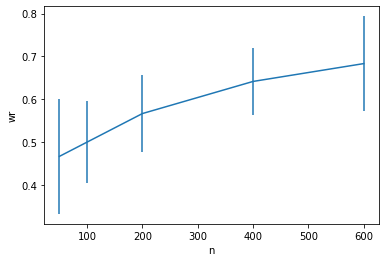

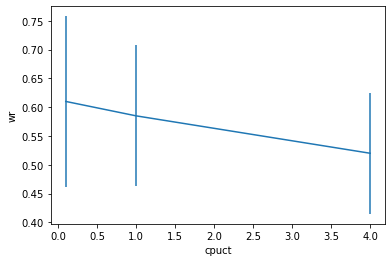

Text(0, 0.5, 'wr')

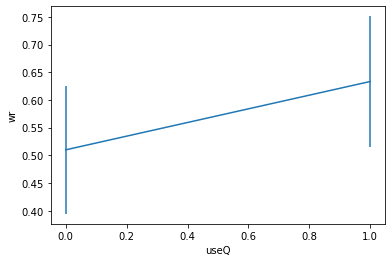

In [34]:
warr = np.zeros((len(ns), len(cpucts), len(useQs)))
for i, j, k in ws.keys():
    warr[i,j,k] = ws[i,j,k]

    
plt.errorbar(ns, warr.mean((1,2)), warr.std((1,2)))
plt.xlabel('n')
plt.ylabel('wr')
plt.show()
    
plt.errorbar(cpucts, warr.mean((0,2)), warr.std((0,2)))
plt.xlabel('cpuct')
plt.ylabel('wr')
plt.show()
    
plt.errorbar([0,1], warr.mean((0,1)), warr.std((0,1)))
plt.xlabel('useQ')
plt.ylabel('wr')

In [47]:
from sklearn import linear_model
md = linear_model.LinearRegression()
md.fit([(n, cpuct, useQ) for n in ns for cpuct in cpucts for useQ in useQs], warr.flatten())
md.coef_

array([ 0.00039223, -0.02272182,  0.12333333])

In [23]:
#  300  0.45
#  800  0.65
# 1200  0.65
# 1600  0.6
# 2400  0.75
# 2800  0.75
# 3200  0.8
# 3600  0.6
# 4000  0.75
# 4400  0.6
# 4800  0.8

winrate = pit(MultiMCTS(nparallel=20, nsearches=4400, net=net), MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)
print(winrate)

1 1
2 2
3 3
4 4
5 5
5 6
6 7
6 8
7 9
7 10
7 11
8 12
8 13
9 14
9 15
10 16
10 17
11 18
12 19
12 20
0.6


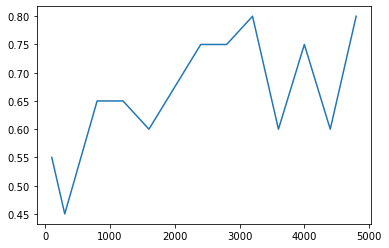

In [24]:
plt.plot([100, 300, 800, 1200, 1600, 2400, 2800, 3200, 3600, 4000, 4400, 4800], [0.55, 0.45, 0.65, 0.65, 0.6, 0.75, 0.75, 0.8, 0.6, 0.75, 0.6, 0.8])

In [32]:
pit(MultiMCTS(nparallel=20, nsearches=300, net=NetAdaptive('net_temp.dat'), params={'useQ':True,'cpuct':0.2}),
    MultiMCTS(nparallel=20, nsearches=300, net=NetAdaptive('net_depth3.dat'), params={'useQ':True,'cpuct':0.2}),
            n=50, nrnd=2, frame=1, verbose=1)

0 1
1 2
2 3
2 4
3 5
3 6
3 7
3 8
4 9
4 10
5 11
5 12
6 13
6 14
7 15
7 16
7 17
8 18
8 19
9 20
9 21
10 22
10 23
11 24
11 25
11 26
11 27
11 28
12 29
13 30
14 31
14 32
15 33
16 34
16 35
17 36
17 37
17 38
18 39
18 40
19 41
19 42
20 43
20 44
21 45
21 46
22 47
22 48
22 49
22 50


0.44

In [9]:
# neu: 0.82
# alt: 0.78

0.8200000000000001

In [47]:
pit(MultiMCTS(nparallel=20, nsearches=300, net=net2, params={'useQ':True,'cpuct':0.2}),
    MultiMCTS(nparallel=20, nsearches=300, net=Net(),  params={'useQ':True,'cpuct':0.2}),
            n=50, nrnd=2, frame=1, verbose=1)

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


KeyboardInterrupt: 

In [36]:

# Batch generator for neural network training





def batchgen(gamerecords, size=50, istart=0, iend=0, augment=True, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    if not iend: iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ps = np.zeros((size, SX, SY, 1))
            vs = np.zeros((size, 1))
            for i, k in enumerate(mb):
                s, a, r = gamerecords[k]
                s = s.copy()
                
                rnd = np.random.rand
                if rnd()<.5:
                    s = GameClass.mirrorx_state(s)
                    a = GameClass.mirrorx_action(a)
                if rnd()<.5:
                    s = GameClass.mirrory_state(s)
                    a = GameClass.mirrorx_action(a)
                if rnd()<.5:
                    s = GameClass.mirror_transpose_state(s)
                    a = GameClass.mirror_transpose_action(a)
                    
                xs[i] = encode_x(s.sea, s.det)
                ps[i, a] = 1.
                vs[i] = r
                    
            yield xs, ps, vs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
         
        
        
        

def train(net, gamerecords, gamerecords_legacy=None, iterations=4000, verbose=0):
    '''Trainiert das Netz'''

    try: net.optimizer
    except:
        net.optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=0e-4)
    optimizer = net.optimizer
    bg_v = batchgen(gamerecords, iend=500, size=500)
    bg_s = batchgen(gamerecords, istart=500, size=200, verbose='supervised')
    #bg_u = batchgen(gamerecords_legacy, size=400)
    celoss = nn.CrossEntropyLoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(torch.sum(-yt*torch.log(yp+1e-12), dim=1))
    losses1 = []
    losses2 = []
    ###semlosses = []
    ###mtlosses = []


    def valloss():
        x, tp, tv = next(bg_v)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)

        loss1 = LogLoss(pp, tp)
        loss2 = 100*MSE(pv[:,0], tv[:,0])
        return loss1.item(), loss2.item()

    
    for k in trange(iterations):
        x, tp, tv = next(bg_s)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)
        #tp = tp.type(torch.long)

        loss1 = LogLoss(pp, tp)
        loss2 = 100*MSE(pv[:,0], tv[:,0])
        loss = loss1 + loss2
        loss.backward()

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()

        # Statistic
        losses1 += [loss1.item()]
        losses2 += [loss2.item()]

        # Verbose output, measure minimum val loss
        if len(losses1) == 100:
            vloss1, vloss2 = valloss()
            if verbose>=1:
                print('Loss1=%f, Loss12=%f, ValLoss1=%f, ValLoss2=%f'% (np.mean(losses1), np.mean(losses2), vloss1, vloss2))
            losses1, losses2 = [], []
            
    return net

In [41]:
from bs_net import *

net = Net()

train(net, game_rec, iterations=40000, verbose=1);

  0%|          | 0/40000 [00:00<?, ?it/s]

Loss1=8.767430, Loss12=5.025565, ValLoss1=8.806741, ValLoss2=0.158186
Loss1=8.755844, Loss12=0.120487, ValLoss1=8.805899, ValLoss2=0.154036
Loss1=8.746100, Loss12=0.113613, ValLoss1=8.796365, ValLoss2=0.143642
Loss1=8.744250, Loss12=0.108822, ValLoss1=8.759356, ValLoss2=0.144971
Loss1=8.749644, Loss12=0.104961, ValLoss1=8.731627, ValLoss2=0.140736
Loss1=8.759925, Loss12=0.113140, ValLoss1=8.823671, ValLoss2=0.182018
Loss1=8.733390, Loss12=0.103275, ValLoss1=8.842050, ValLoss2=0.145089
Loss1=8.755458, Loss12=0.102693, ValLoss1=8.786756, ValLoss2=0.135412
Loss1=8.772931, Loss12=0.100614, ValLoss1=8.805155, ValLoss2=0.148131
Loss1=8.757024, Loss12=0.101777, ValLoss1=8.740667, ValLoss2=0.146493
Loss1=8.763917, Loss12=0.102073, ValLoss1=8.851178, ValLoss2=0.133322
Loss1=8.755617, Loss12=0.101920, ValLoss1=8.722224, ValLoss2=0.194886
Loss1=8.753306, Loss12=0.104590, ValLoss1=8.722218, ValLoss2=0.188637
Loss1=8.739715, Loss12=0.099554, ValLoss1=8.786685, ValLoss2=0.141630
Loss1=8.762045, Loss

Loss1=8.747060, Loss12=0.053791, ValLoss1=8.841926, ValLoss2=0.152130
Loss1=8.764560, Loss12=0.053322, ValLoss1=8.832716, ValLoss2=0.166024
Loss1=8.757191, Loss12=0.052398, ValLoss1=8.768245, ValLoss2=0.153209
Loss1=8.742455, Loss12=0.052958, ValLoss1=8.841928, ValLoss2=0.165741
Loss1=8.767783, Loss12=0.052242, ValLoss1=8.869558, ValLoss2=0.142994
Loss1=8.779526, Loss12=0.056527, ValLoss1=8.777454, ValLoss2=0.175535
Loss1=8.763408, Loss12=0.052823, ValLoss1=8.841928, ValLoss2=0.142722
Loss1=8.737159, Loss12=0.055802, ValLoss1=8.823506, ValLoss2=0.175291
Loss1=8.755349, Loss12=0.057643, ValLoss1=8.795875, ValLoss2=0.172945
Loss1=8.752817, Loss12=0.050573, ValLoss1=8.777454, ValLoss2=0.181568
Loss1=8.770086, Loss12=0.052936, ValLoss1=8.777454, ValLoss2=0.139648
supervised: finished one epoch (7)!
Loss1=8.746600, Loss12=0.049227, ValLoss1=8.795875, ValLoss2=0.154095
Loss1=8.763869, Loss12=0.050685, ValLoss1=8.795876, ValLoss2=0.158564
Loss1=8.741995, Loss12=0.046011, ValLoss1=8.814296, Va

Loss1=8.747521, Loss12=0.033657, ValLoss1=8.731403, ValLoss2=0.164625
Loss1=8.744758, Loss12=0.034841, ValLoss1=8.795877, ValLoss2=0.137948
Loss1=8.766402, Loss12=0.034826, ValLoss1=8.814296, ValLoss2=0.139861
Loss1=8.765711, Loss12=0.035728, ValLoss1=8.786665, ValLoss2=0.145301
Loss1=8.752817, Loss12=0.033309, ValLoss1=8.722192, ValLoss2=0.141132
Loss1=8.754659, Loss12=0.034610, ValLoss1=8.823506, ValLoss2=0.158002
Loss1=8.768935, Loss12=0.035046, ValLoss1=8.869558, ValLoss2=0.152263
supervised: finished one epoch (14)!
Loss1=8.778145, Loss12=0.032642, ValLoss1=8.851137, ValLoss2=0.145229
Loss1=8.766402, Loss12=0.032637, ValLoss1=8.887979, ValLoss2=0.151794
Loss1=8.745909, Loss12=0.032650, ValLoss1=8.722194, ValLoss2=0.142913
Loss1=8.748442, Loss12=0.034602, ValLoss1=8.703771, ValLoss2=0.153961
Loss1=8.741994, Loss12=0.033791, ValLoss1=8.777454, ValLoss2=0.141606
Loss1=8.746139, Loss12=0.032258, ValLoss1=8.694561, ValLoss2=0.150985
Loss1=8.740843, Loss12=0.032122, ValLoss1=8.814296, V

Loss1=8.740843, Loss12=0.023149, ValLoss1=8.851137, ValLoss2=0.151829
Loss1=8.755349, Loss12=0.023722, ValLoss1=8.722192, ValLoss2=0.150282
Loss1=8.772388, Loss12=0.023445, ValLoss1=8.814296, ValLoss2=0.166426
supervised: finished one epoch (21)!
Loss1=8.751665, Loss12=0.022787, ValLoss1=8.768244, ValLoss2=0.160330
Loss1=8.742685, Loss12=0.024372, ValLoss1=8.786665, ValLoss2=0.144652
Loss1=8.759724, Loss12=0.023488, ValLoss1=8.777454, ValLoss2=0.153327
Loss1=8.744527, Loss12=0.022051, ValLoss1=8.841928, ValLoss2=0.142935
Loss1=8.754198, Loss12=0.022187, ValLoss1=8.768244, ValLoss2=0.161083
Loss1=8.750284, Loss12=0.021540, ValLoss1=8.851137, ValLoss2=0.151784
Loss1=8.756270, Loss12=0.022282, ValLoss1=8.740613, ValLoss2=0.155513
Loss1=8.745909, Loss12=0.022436, ValLoss1=8.777454, ValLoss2=0.136265
Loss1=8.754198, Loss12=0.022174, ValLoss1=8.722192, ValLoss2=0.138984
Loss1=8.754198, Loss12=0.021568, ValLoss1=8.814296, ValLoss2=0.141955
Loss1=8.770777, Loss12=0.022718, ValLoss1=8.832716, V

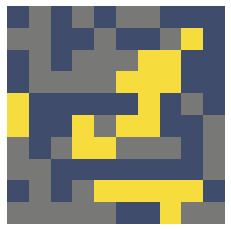

0.43133482336997986


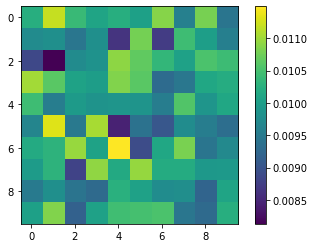

In [26]:
# vorhersage auf zufälliger sea
s = newrandomstate()
plot_state(s)
plt.show()
p, v = net(np2t([encode_x(s.sea, s.det)]))
plt.imshow(t2np(p)[0,0])
plt.colorbar()
print(v.item())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

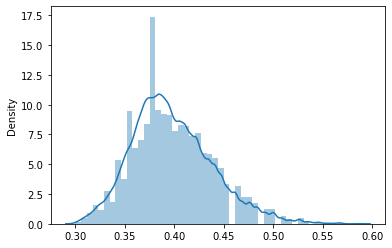

In [7]:
# Verteilung in gamerecords von r
import seaborn as sns
sns.distplot([ r for s, a, r in gamerecords ])

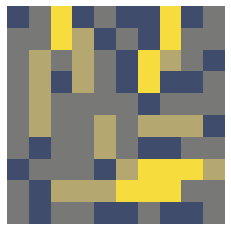

0.45624688267707825 0.37037037037037035


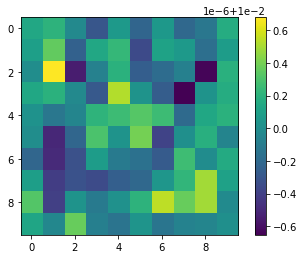

In [43]:
# Vergleich r in gamerecords mit vorhersage des nnet
s, a, r = game_rec[np.random.choice(range(len(game_rec)))]
plot_state(s)
plt.show()
p, v = net(np2t([encode_x(s.sea, s.det)]))
plt.imshow(t2np(p)[0,0])
plt.colorbar()
print(v.item(), r)